In [1]:
from IPython.core.display import HTML
with open ("../style.css", "r") as file:
    css = file.read()
HTML(css)

In [2]:
%load_ext nb_mypy

Version 1.0.5


# An Interpreter for a Simple Programming Language

In this notebook we develop an interpreter for a small programming language.
The grammar for this language is stored in the file `Pure.g4`.

In [4]:
!cat -n Pure.g4

     1	grammar Pure;
     2	
     3	program  : statement+
     4	         ;
     5	
     6	statement: VAR ':=' expr ';'
     7	         | 'print' '(' expr ')' ';'
     8	         | 'if'    '(' boolExpr ')' '{' statement* '}'
     9	         | 'while' '(' boolExpr ')' '{' statement* '}'
    10	         ;
    11	
    12	boolExpr : expr '==' expr
    13	         | expr '<'  expr
    14	         ;
    15	
    16	expr     : expr '+' product
    17	         | expr '-' product
    18	         | product
    19	         ;
    20	
    21	product  : product '*' factor
    22	         | product '/' factor
    23	         | factor
    24	         ;
    25	
    26	factor   : 'read' '(' ')'
    27	         | '(' expr ')'
    28	         | VAR
    29	         | NUMBER
    30	         ;
    31	
    32	VAR      : [a-zA-Z][a-zA-Z_0-9]*;
    33	NUMBER   : '0'|[1-9][0-9]*;
    34	
    35	MULTI_COMMENT : '/*' .*? '*/' -> skip;
    36	LINE_COMMENT  : '//' ~('\n')* -> skip;
    37	WS            : [ \t\n\r]   

The grammar shown above does only contain `skip` actions.  The corrsponding grammar that is enriched with all semantic actions is stored in the file `Simple.g4`.

An example program that conforms to this grammar is stored in the file `sum.sl`.

In [3]:
!cat sum.sl

n := read();
s := 0;
i := 0;
while (i < n * n) {
    i := i + 1;
    s := s + i;
}
print(s);


The file `Simple.g4` contains a parser for the language described by the grammar `Pure.g4`. This parser returns
an abstract syntax tree.  This tree is represented as a *nested tuple*.

In [5]:
!cat -n Simple.g4

     1	grammar Simple;
     2	
     3	program returns [stmnt_list] 
     4	    : {SL = ['program']} (s = statement {SL.append($s.stmnt)})+ {$stmnt_list = tuple(SL)}
     5	    ;
     6	
     7	statement returns [stmnt]
     8	    : v = VAR ':=' e = expr ';'       {$stmnt = (':=', $v.text, $e.result)}
     9	    | 'print' '(' r = expr ')' ';'    {$stmnt = ('print', $r.result)}
    10	    | 'if' '(' b = boolExpr ')' {SL = []} '{' (l = statement {SL.append($l.stmnt) })* '}' 
    11	      {$stmnt = ('if', $b.result) + tuple(SL)}
    12	    | 'while' '(' b = boolExpr ')' {SL = []} '{' (l = statement {SL.append($l.stmnt) })* '}' 
    13	      {$stmnt = ('while', $b.result) + tuple(SL)}
    14	    ;
    15	
    16	boolExpr returns [result]
    17	    : l = expr '==' r = expr {$result = ('==', $l.result, $r.result)} 
    18	    | l = expr '<'  r = expr {$result = ('<',  $l.result, $r.result)}
    19	    ;
    20	
    21	expr returns [result]
    22	    : e = expr '+' p = product {$result = ('+

The parser shown above will transform the program `sum.sl` into the *nested tuple* stored in the file `sum.ast`.

In [6]:
!cat sum.ast

('program',
    (':=', 'n', ('read',)),
    (':=', 's', 0),
    (':=', 'i', 0),
    ('while',
 	('<',  'i', ('*', 'n', 'n')),
     	(':=', 'i', ('+', 'i', 1)),
 	(':=', 's', ('+', 's', 'i'))
    ),
    ('print', 's')
)

In [7]:
!antlr4 -Dlanguage=Python3 Simple.g4

In [8]:
from SimpleLexer  import SimpleLexer
from SimpleParser import SimpleParser
import antlr4

In [9]:
%run AST-2-Dot.ipynb

The function `main` takes one parameter `file`.  This parameter is a string specifying the name of file containing a program.  
The function reads this program and executes it.

In [10]:
def main(file):
    with open(file, 'r') as handle:
        program_text = handle.read()
    input_stream  = antlr4.InputStream(program_text)
    lexer         = SimpleLexer(input_stream)
    token_stream  = antlr4.CommonTokenStream(lexer)
    parser        = SimpleParser(token_stream)
    result        = parser.program()
    Statements    = result.stmnt_list
    ast           = tuple2dot(Statements)
    print(Statements)
    display(ast)
    ast.render('ast', view=True) # store the tree in the file 'ast'
    execute_tuple(Statements)

('program', (':=', 'n', ('read',)), (':=', 's', 0), (':=', 'i', 0), ('while', ('<', 'i', ('*', 'n', 'n')), (':=', 'i', ('+', 'i', 1)), (':=', 's', ('+', 's', 'i'))), ('print', 's'))


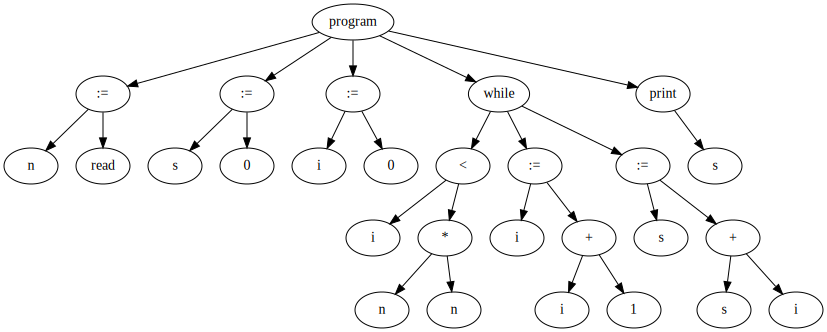

NameError: name 'execute_tuple' is not defined

In [11]:
main('sum.sl')

In [12]:
from typing import TypeVar
NestedTuple = TypeVar('NestedTuple')
NestedTuple = int | str | tuple[NestedTuple, ...]
Number      = int | float

We need some forward declarations.

In [13]:
def execute(stmnt: NestedTuple, Values: dict[str, Number]) -> None:
    return None

In [14]:
def evaluate(expr: NestedTuple, Values: dict[str, Number]) -> Number:
    return None # type: ignore

In [15]:
def evaluate_bool(expr: NestedTuple, Values: dict[str, Number]) -> bool:
    return None # type: ignore

The function `execute_tuple` takes two arguments:
- `Statement_List` is a list of statements,
- `Values` is a dictionary assigning integer values to variable names.

The function executes the statements in `Statement_List`.  If an assignment statement is executed,
the dictionary `Values` is updated.

In [16]:
def execute_tuple(Statement_List: tuple[NestedTuple, ...], Values: dict[str, Number]={}) -> None:
    for stmnt in Statement_List:
        execute(stmnt, Values)

The function `execute` takes two arguments:
- `stmnt` is a statement,
- `Values` is a dictionary assigning values to variable names.

The function executes the statements in `Statement_List`.  If an assignment statement is executed,
the dictionary `Values` is updated.

In [17]:
def execute(stmnt: NestedTuple, Values: dict[str, Number]) -> None:
    match stmnt:
        case 'program':
            pass
        case (':=', var, value):
            Values[var] = evaluate(value, Values)
        case ('print', expr):
            print(evaluate(expr, Values))
        case ('if', test, *SL):
            if evaluate_bool(test, Values):
                execute_tuple(tuple(SL), Values)
        case ('while', test, *SL):
            while evaluate_bool(test, Values):
                execute_tuple(tuple(SL), Values)
        case _:
            assert False, f'{stmnt} unexpected'

The function `evaluate_bool` takes two arguments:
- `expr` is a boolean expression expression,
- `Values` is a dictionary assigning integer values to variable names.

The function evaluates the given expression and returns this value.

In [18]:
def evaluate_bool(expr: NestedTuple, Values: dict[str, Number]) -> bool:
    match expr:
        case ('==', lhs, rhs):
            return evaluate(lhs, Values) == evaluate(rhs, Values)
        case ('<', lhs, rhs):
            return evaluate(lhs, Values) < evaluate(rhs, Values)
        case _:
            assert False, f'{expr} unexpected'

The function `evaluate` takes two arguments:
- `expr` is a logical expression or an arithmetic expression,
- `Values` is a dictionary assigning integer values to variable names.

The function evaluates the given expression and returns this value.

In [19]:
def evaluate(expr: NestedTuple, Values: dict[str, Number]) -> Number:
    match expr:
        case int():
            return expr
        case str():
            return Values[expr] 
        case ('read',):
            return int(input('Please enter a natural number: '))
        case ('+', lhs, rhs):
            return evaluate(lhs, Values) + evaluate(rhs, Values)
        case ('-', lhs, rhs):
            return evaluate(lhs, Values) - evaluate(rhs, Values)
        case ('*', lhs, rhs):
            return evaluate(lhs, Values) * evaluate(rhs, Values)
        case ('/', lhs, rhs):
            return evaluate(lhs, Values) / evaluate(rhs, Values)
        case _:
            assert False, f'{expr} unexpected'

In [20]:
!cat sum.sl

n := read();
s := 0;
i := 0;
while (i < n * n) {
    i := i + 1;
    s := s + i;
}
print(s);


('program', (':=', 'n', ('read',)), (':=', 's', 0), (':=', 'i', 0), ('while', ('<', 'i', ('*', 'n', 'n')), (':=', 'i', ('+', 'i', 1)), (':=', 's', ('+', 's', 'i'))), ('print', 's'))


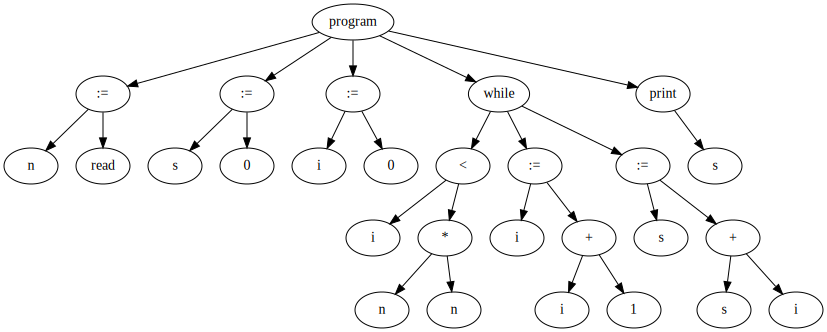

Please enter a natural number: 10
5050


In [22]:
main('sum.sl')

In [23]:
!cat factorial.sl

f := 1;
i := 0;
n := read();
while (i < n) {
    i := i + 1;
    f := i * f;
}
print(f);



('program', (':=', 'f', 1), (':=', 'i', 0), (':=', 'n', ('read',)), ('while', ('<', 'i', 'n'), (':=', 'i', ('+', 'i', 1)), (':=', 'f', ('*', 'i', 'f'))), ('print', 'f'))


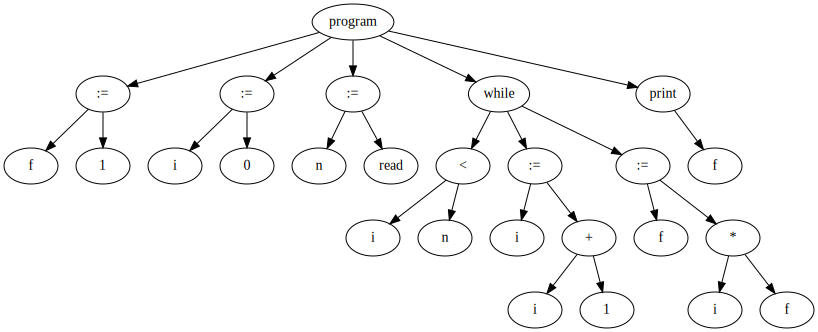

Please enter a natural number: 5
120


In [24]:
main('factorial.sl')

In [ ]:
!rm *.py *.tokens *.interp
!rm ast
!rm -r __pycache__/
!rm *.pdf

In [ ]:
!ls -l